# Chest X-Ray Pneumonia Classification

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Dataset Link - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Acknowledgements
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

#### Importing the libraries

We will design a Deep Learning Model to classify the images.
We will be using Tensorflow 2.0 for the Pneumonia Classification. 

Tensorflow Documentation -https://www.tensorflow.org/tutorials

Keras Documentation - https://keras.io/

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#### Preprocessing Images

In [2]:
image_size = 256       #resize all images to 256*256

labels = ['NORMAL', 'PNEUMONIA']          #labels from the folders

In [3]:
def create_training_data(paths):              #creating the training data
    
    images = []
    
    for label in labels:
        dir = os.path.join(paths,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):    #going through all the images in different folders and resizing them
            
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
            
    return np.array(images)

These cells will take time to execute. 

In [4]:
train = create_training_data('D:/Kaggle datasets/Pneumonia Classification/train')

In [5]:
test = create_training_data('D:/Kaggle datasets/Pneumonia Classification/test')

In [6]:
val = create_training_data('D:/Kaggle datasets/Pneumonia Classification/val')

Checking the shapes of all the train, test and val sets.

In [7]:
train.shape

(5216, 2)

In [8]:
test.shape

(624, 2)

In [9]:
val.shape

(16, 2)

The first index indicates the number of images, and the second index, the number of folders.

#### Visualizing some images

NORMAL


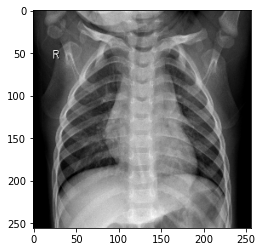

In [10]:
plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])             #label

PNEUMONIA


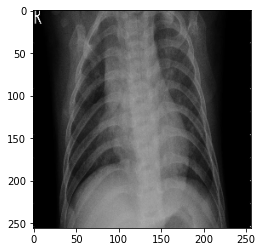

In [11]:
plt.imshow(train[5000][0], cmap='gray')
print(labels[train[5000][1]])

#### Loading the images and labels together

In [12]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)

#### Reshaping dimensions before feeding them to the neural network.

In [13]:
X_new = np.array(X).reshape(-1, image_size, image_size, 1)
y_new = np.array(y)
y_new = np.expand_dims(y_new, axis =1)

If we go through the dataset, we see that there are a lot more Pneumonia images than Normal images. So we load the images from train and test set together, and split them using the train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We will use 20% of the images for testing and the remaining 80% for training the Neural network.

The Validation images (val) will not be shown to the neural network and will be used later to see on how the neural network performs on predicting images, that it has never seen before.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state = 32)

In [15]:
X_train.shape

(4672, 256, 256, 1)

In [16]:
X_test.shape

(1168, 256, 256, 1)

In [17]:
y_train.shape

(4672, 1)

In [18]:
y_test.shape

(1168, 1)

We see that the images have been properly resized to 256*256.

In [19]:
X_train = X_train / 255            # normalizing
X_test = X_test / 255

### Creating the CNN Model:

Convolutional Neural Network (CNN) Detailed description- https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

![Image of CNN](https://miro.medium.com/max/1000/1*zNs_mYOAgHpt3WxbYa7fnw.png)

In [20]:
i = Input(X_train.shape[1:])                                        # Input Layer

a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)      # Convolution
a = BatchNormalization()(a)                                         # Batch Normalization
a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)                                            # Max Pooling

a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = MaxPooling2D(2,2)(a)

a = Flatten()(a)                                                      # Flatten
a = Dense(512, activation = 'relu')(a)                               # Fully Connected layer
a = Dropout(0.4)(a)
a = Dense(512, activation = 'relu')(a)
a = Dropout(0.3)(a)
a = Dense(512, activation = 'relu')(a)
a = Dropout(0.1)(a)

a = Dense(1, activation = 'sigmoid')(a)                               # Output Layer

model = Model(i,a)

#### Compiling and viewing the model summary

In [21]:
model.compile(optimizer=Adam(lr = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()                   

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496 

#### Data Augmentation 

Data augmentation - https://www.tensorflow.org/tutorials/images/data_augmentation

In [22]:
batch_size = 4

train_gen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

train_generator = train_gen.flow(X_train,y_train,batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

In [23]:
checkpoint = ModelCheckpoint('Pneumonia1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

#to save the model - epochs with best validation loss

#### Training the Model

In [24]:
r = model.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs= 15,
                       callbacks = [checkpoint])

  ...
    to  
  ['...']
Train for 1168 steps, validate on 1168 samples
Epoch 1/15
1167/1168 [============================>.] - ETA: 0s - loss: 0.8417 - accuracy: 0.8162
Epoch 00001: val_loss improved from inf to 1.25767, saving model to Pneumonia1.h5
1168/1168 [==============================] - 35s 30ms/step - loss: 0.8410 - accuracy: 0.8164 - val_loss: 1.2577 - val_accuracy: 0.7474
Epoch 2/15
1166/1168 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.8491
Epoch 00002: val_loss improved from 1.25767 to 0.28235, saving model to Pneumonia1.h5
1168/1168 [==============================] - 31s 27ms/step - loss: 0.5689 - accuracy: 0.8489 - val_loss: 0.2823 - val_accuracy: 0.9144
Epoch 3/15
1166/1168 [============================>.] - ETA: 0s - loss: 0.4683 - accuracy: 0.8669
Epoch 00003: val_loss did not improve from 0.28235
1168/1168 [==============================] - 31s 26ms/step - loss: 0.4677 - accuracy: 0.8669 - val_loss: 0.3302 - val_accuracy: 0.9024
Epoch 4/15

#### Plotting The Loss 

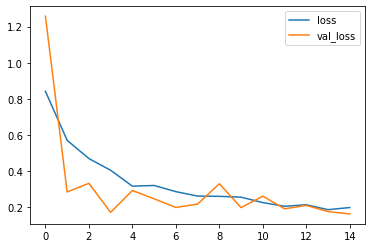

In [25]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

#### Loading the model and trying to improve further

In [26]:
new_model = tf.keras.models.load_model('Pneumonia1.h5')   #loading model to train further

In [28]:
new_model.compile(optimizer = Adam(lr = 0.00003), loss = 'binary_crossentropy', metrics = ['accuracy']) 

checkpoint1 = ModelCheckpoint('Pneumonia2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

batch_size = 4

r1 = new_model.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint1])

  ...
    to  
  ['...']
Train for 1168 steps, validate on 1168 samples
Epoch 1/10
1166/1168 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8789
Epoch 00001: val_loss improved from inf to 0.22025, saving model to Pneumonia2.h5
1168/1168 [==============================] - 33s 28ms/step - loss: 0.3139 - accuracy: 0.8791 - val_loss: 0.2202 - val_accuracy: 0.9272
Epoch 2/10
1166/1168 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.9024
Epoch 00002: val_loss improved from 0.22025 to 0.20188, saving model to Pneumonia2.h5
1168/1168 [==============================] - 32s 27ms/step - loss: 0.2655 - accuracy: 0.9026 - val_loss: 0.2019 - val_accuracy: 0.9289
Epoch 3/10
1167/1168 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9139
Epoch 00003: val_loss improved from 0.20188 to 0.19586, saving model to Pneumonia2.h5
1168/1168 [==============================] - 32s 27ms/step - loss: 0.2250 - accuracy: 0.9140 - val_loss: 0.195

In [30]:
new_model.compile(optimizer = Adam(lr = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy']) 

checkpoint1 = ModelCheckpoint('Pneumonia3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

batch_size = 4

r1 = new_model.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint1])

  ...
    to  
  ['...']
Train for 1168 steps, validate on 1168 samples
Epoch 1/10
1165/1168 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9397
Epoch 00001: val_loss improved from inf to 0.19139, saving model to Pneumonia3.h5
1168/1168 [==============================] - 32s 28ms/step - loss: 0.1703 - accuracy: 0.9396 - val_loss: 0.1914 - val_accuracy: 0.9315
Epoch 2/10
1167/1168 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9449
Epoch 00002: val_loss improved from 0.19139 to 0.19034, saving model to Pneumonia3.h5
1168/1168 [==============================] - 32s 27ms/step - loss: 0.1532 - accuracy: 0.9450 - val_loss: 0.1903 - val_accuracy: 0.9349
Epoch 3/10
1166/1168 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9395
Epoch 00003: val_loss improved from 0.19034 to 0.17701, saving model to Pneumonia3.h5
1168/1168 [==============================] - 32s 27ms/step - loss: 0.1573 - accuracy: 0.9396 - val_loss: 0.177

We see that even though the loss did not drop too much, but now the model is more stable, that is, it is not having too many spikes in the validation loss and accuracy. The loss just changes between 14 to 15%.

In [31]:
final_model = tf.keras.models.load_model('Pneumonia3.h5')

In [32]:
pred = final_model.predict(X_test, batch_size = 8)
pred

array([[0.4377475 ],
       [0.06843796],
       [0.99051136],
       ...,
       [0.02480499],
       [0.08551272],
       [1.        ]], dtype=float32)

In [36]:
pred_final = np.where(pred>0.5,1,0)
pred_final

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

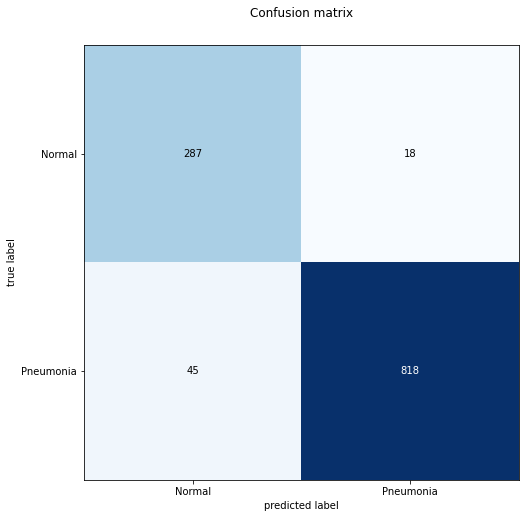

In [37]:
# Get the confusion matrix
CM = confusion_matrix(y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [40]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [41]:
tp, fp, tn ,fn = perf_measure(y_test,pred_final)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.98
Precision of the model is 0.95
F-Score is 0.96
